# IEEE Fraud Detection Kaggle Competition
## LightGBM V feats feature engineering

In [2]:
%%bash

ls -l

echo ''

cd ../data

ls -l

echo ''

cd ../output

ls -l

total 20072
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadha2  749149485   222386 Aug  8 22:25 adverserial_validation.ipynb
-rw-r--r--  1 cchadha2  749149485   239908 Aug 12 23:40 lgb_<2_importance_removed_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   683228 Aug 15 15:22 lgb_HasVfeats.ipynb
-rw-r--r--  1 cchadha2  749149485   904934 Aug 15 18:18 lgb_HasVfeats2.ipynb
-rw-r--r--  1 cchadha2  749149485   614375 Aug 12 23:36 lgb_TransactionDay.ipynb
-rw-r--r--  1 cchadha2  749149485   869663 Aug 13 10:19 lgb_TransactionDay_and_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   582482 Aug 14 17:23 lgb_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   238429 Aug 13 00:05 lgb_remove_D9.ipynb
-rw-r--r--  1 cchadha2  749149485   237097 Aug  7 15:28 lightgbm_baseline.ipynb
-rw-r--r--  1 cchadha2  749149485   345397 Aug 12 23:27 lightgbm_card1_count_encoded.i

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

num_folds = 5
SEED = 5000

# Load and prepare data

In [5]:
train = pd.read_csv('../output/train_card1_count.csv')
test = pd.read_csv('../output/test_card1_count.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [6]:
val_indices = np.load('../output/val_indices.npy')

In [7]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [8]:
print(train.shape)

(590540, 435)


In [9]:
print(test.shape)

(506691, 434)


In [10]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 300

In [11]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [12]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

# HasVfeats

Consolidate all some categorical variables into binary variables

In [13]:
train.head(20)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0         2987000        0          86400          68.500         W  13926   
1         2987001        0          86401          29.000         W   2755   
2         2987002        0          86469          59.000         W   4663   
3         2987003        0          86499          50.000         W  18132   
4         2987004        0          86506          50.000         H   4497   
5         2987005        0          86510          49.000         W   5937   
6         2987006        0          86522         159.000         W  12308   
7         2987007        0          86529         422.500         W  12695   
8         2987008        0          86535          15.000         H   2803   
9         2987009        0          86536         117.000         W  17399   
10        2987010        0          86549          75.887         C  16496   
11        2987011        0          86555          16.495         C   4461   
12        2987012        0          86564          50.000         W   3786   
13        2987013        0          86585          40.000         W  12866   
14        2987014        0          86596          10.500         W  11839   
15        2987015        0          86618          57.950         W   7055   
16        2987016        0          86620          30.000         H   1790   
17        2987017        0          86668         100.000         H  11492   
18        2987018        0          86725          47.950         W   4663   
19        2987019        0          86730         186.000         W   7005   

    card2  card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
0     NaN  150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
1   404.0  150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2   490.0  150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
3   567.0  150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
4   514.0  150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   
5   555.0  150.0        visa  226.0   debit  272.0  87.0   36.0    NaN   
6   360.0  150.0        visa  166.0   debit  126.0  87.0    0.0    NaN   
7   490.0  150.0        visa  226.0   debit  325.0  87.0    NaN    NaN   
8   100.0  150.0        visa  226.0   debit  337.0  87.0    NaN    NaN   
9   111.0  150.0  mastercard  224.0   debit  204.0  87.0   19.0    NaN   
10  352.0  117.0  mastercard  134.0  credit    NaN   NaN    NaN    NaN   
11  375.0  185.0  mastercard  224.0   debit    NaN   NaN    NaN   30.0   
12  418.0  150.0        visa  226.0   debit  204.0  87.0    NaN    NaN   
13  303.0  150.0        visa  226.0   debit  330.0  87.0    NaN    NaN   
14  490.0  150.0        visa  226.0   debit  226.0  87.0    NaN    NaN   
15  555.0  150.0        visa  226.0   debit  315.0  87.0    3.0    NaN   
16  555.0  150.0        visa  226.0   debit  170.0  87.0    NaN    NaN   
17  111.0  150.0  mastercard  219.0  credit  204.0  87.0    NaN    NaN   
18  490.0  150.0        visa  166.0   debit  184.0  87.0    5.0    NaN   
19  111.0  150.0        visa  226.0   debit  264.0  87.0    NaN    NaN   

    P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0             NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1       gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2     outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3       yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4       gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
5       gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
6       yahoo.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
7        mail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
8   anonymous.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
9       ya

In [14]:
train['V124'].value_counts()

1.0     546045
2.0      36778
3.0       4856
4.0       2004
5.0        243
6.0        126
0.0         61
7.0         41
8.0         26
9.0         24
10.0        13
11.0         5
12.0         2
13.0         2
Name: V124, dtype: int64

In [15]:
train['V126'].value_counts()

0.000000        510542
117.000000        3407
59.000000         3312
100.000000        2248
49.000000         1753
226.000000        1494
107.949997        1475
50.000000         1460
57.950001         1437
200.000000        1434
150.000000        1185
39.000000         1164
29.000000         1045
171.000000         988
77.000000          924
300.000000         916
335.000000         784
34.000000          781
97.000000          639
25.000000          592
234.000000         587
118.000000         538
75.000000          527
250.000000         519
92.000000          488
30.950001          484
47.950001          484
400.000000         475
554.000000         473
35.950001          468
500.000000         435
209.949997         429
30.000000          415
25.950001          403
280.000000         401
87.000000          382
445.000000         366
141.000000         349
98.000000          346
20.000000          342
40.000000          341
600.000000         331
159.949997         324
15.000000  

Looks like V columns are given dtype of float64 throughout despite some being categorical (such as V124)

In [16]:
for column in ['V' + str(x) for x in range(1,340)]:
    print(train[column].dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


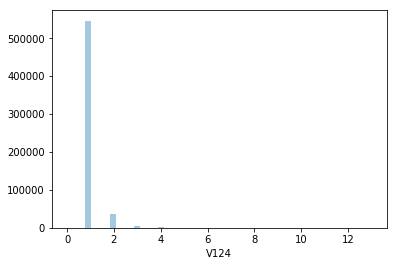

In [17]:
sns.distplot(train['V124'], kde=False)

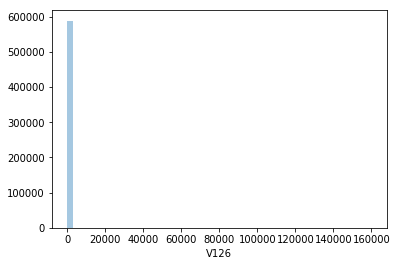

In [18]:
sns.distplot(train['V126'], kde=False)

[V138-V278] missing
[V279-V321] not missing but seem like mostly 0?
[V322-V339] missing

In [19]:
train.isna().all().tolist()

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


No columns completely missing

[V138-V278] missing
[V279-V321] not missing but seem like mostly 0?
[V322-V339] missing

In [20]:
(339) / 3

113.0

In [22]:
train.columns.tolist()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [31]:
v_features = ['V' + str(x) for x in range(1,340)]

In [32]:
id_features = ['id_0' + str(x) for x in range(1,10)]

In [33]:
id_features += id_features + ['id_' + str(x) for x in range(10,39)]

In [34]:
columns_of_interest = v_features + id_features + ['DeviceType', 'DeviceInfo', 'card1_count']

In [35]:
columns_of_interest

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 

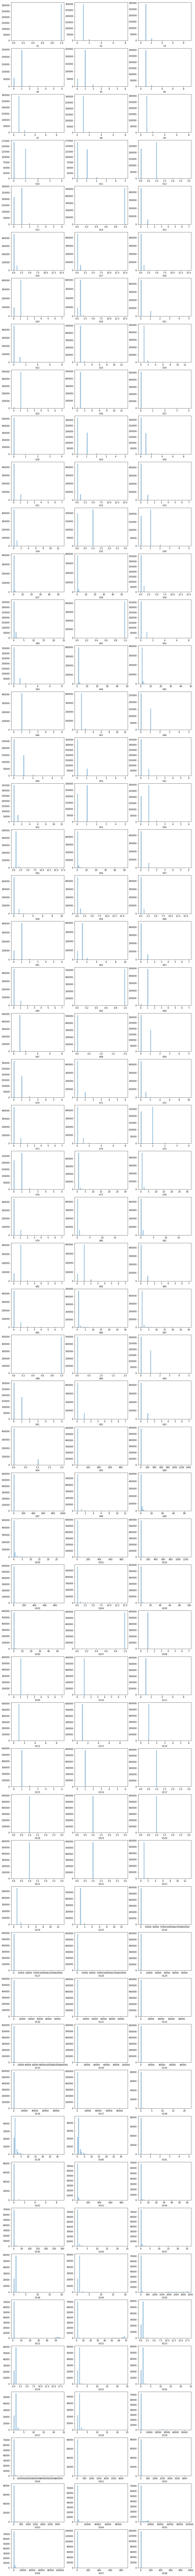

In [46]:
fig, axes = plt.subplots(nrows=56, ncols=3, figsize=(15,220))
#113
for ax, feature in zip(axes.flatten(), v_features[:3*56]):
    
    sns.distplot(train[train[feature].notna()][feature], kde=False, ax=ax)

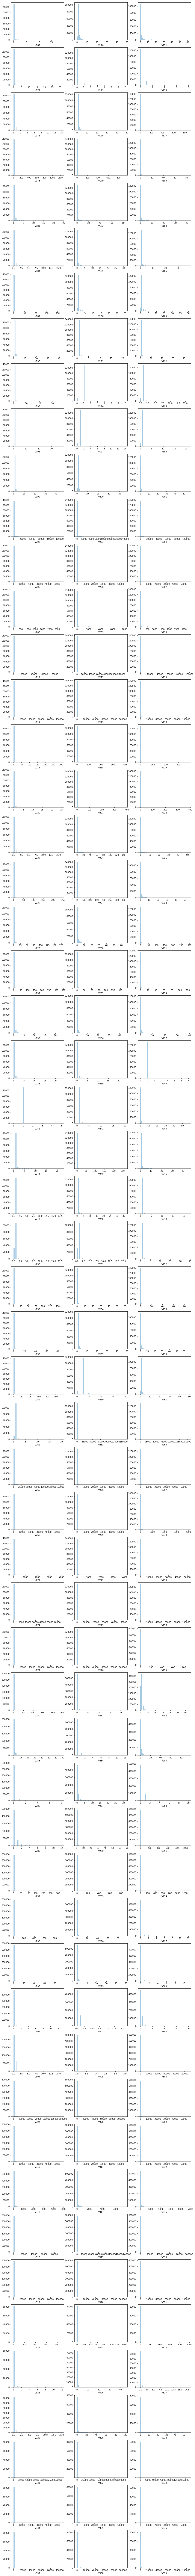

In [47]:
fig, axes = plt.subplots(nrows=57, ncols=3, figsize=(15,220))
#113
for ax, feature in zip(axes.flatten(), v_features[3*56:]):
    
    sns.distplot(train[train[feature].notna()][feature], kde=False, ax=ax)

Would be worth figuring out which of the V features are categorical and which are numerical from above plots and setting dtype accordingly. Try to infer what top V features are. The rows that have ID information have values for some V features where the rows without ID information wouldn't - could these be used to group types of users together or even find specific users? Additionally, the values of these features where the rows have ID info should be examined for their distributions as if the values are constant throughout the rows with ID info, we can consolidate these features into a binary variable (as per HasVfeats notebook).

In [49]:
train.loc[:,v_features].sample(30)

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
159737  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
553743  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
250581  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
371916  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
519259  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
140529  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
185020  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
557143  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
464246  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
109147  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
72925   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
515461  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
133096  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
404709  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
211405  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
186759  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
262158  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
509462  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
187207  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
369525  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
308776  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
299158  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
128955  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
570556  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
263418  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
60200   1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
520832  1.0  1.0  1.0  1.0  3.0  1.0  2.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
97001   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
29122   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
73269   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
159737  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
553743  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
250581  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
371916  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
519259  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
140529  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
185020  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
557143  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
464246  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
109147  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
72925   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
515461  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
133096  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
404709  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
211405  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
186759  0.0  0.0  0.0  0.0  2.0  2.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
262158  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  0.0  0.0   
509462  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
187207  

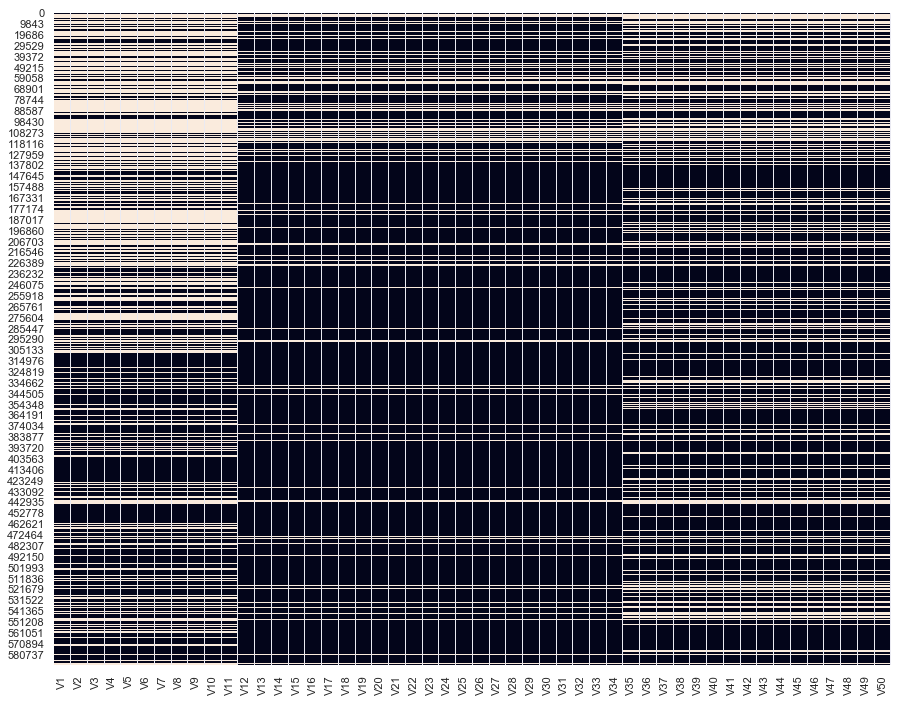

In [75]:
plt.figure(figsize=(15,12))
sns.heatmap(train.loc[:, v_features[:50]].isna(), cbar=False)
plt.show()

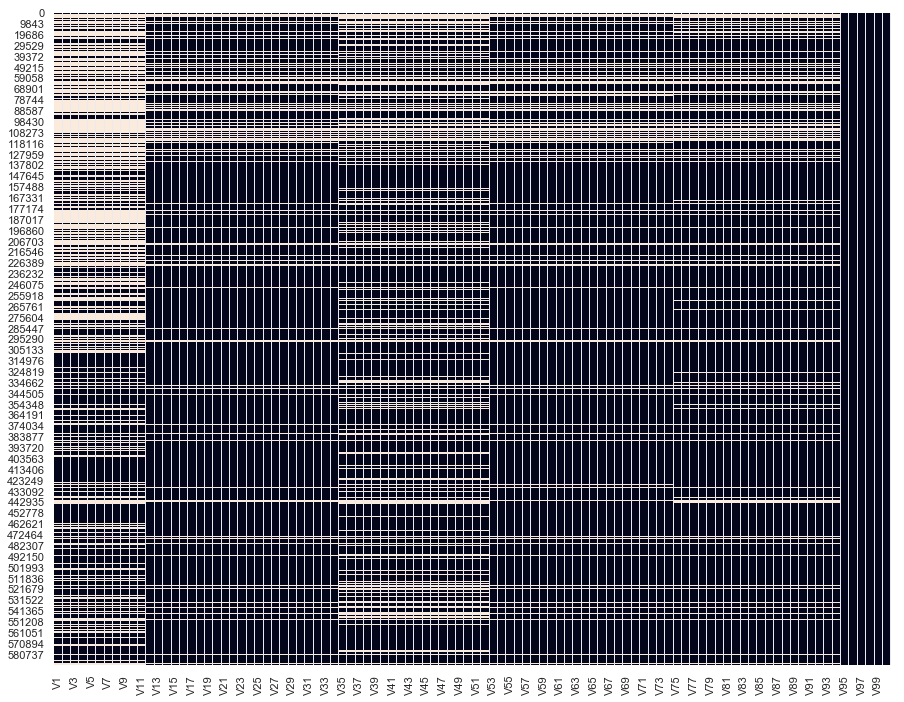

In [76]:
plt.figure(figsize=(15,12))
sns.heatmap(train.loc[:, v_features[:100]].isna(), cbar=False)
plt.show()

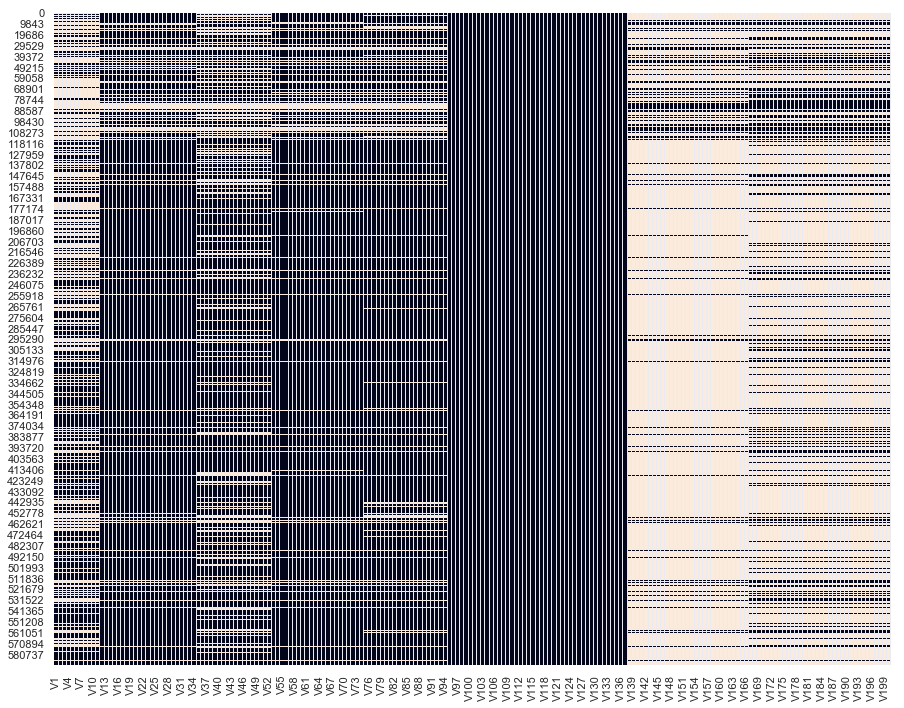

In [77]:
plt.figure(figsize=(15,12))
sns.heatmap(train.loc[:, v_features[:200]].isna(), cbar=False)
plt.show()

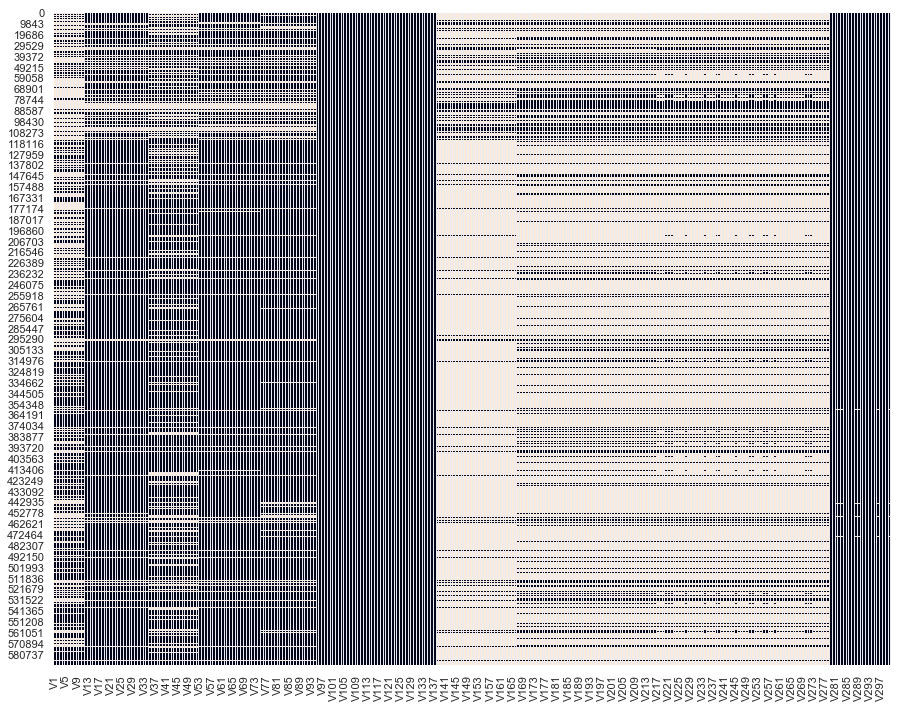

In [78]:
plt.figure(figsize=(15,12))
sns.heatmap(train.loc[:, v_features[:300]].isna(), cbar=False)
plt.show()

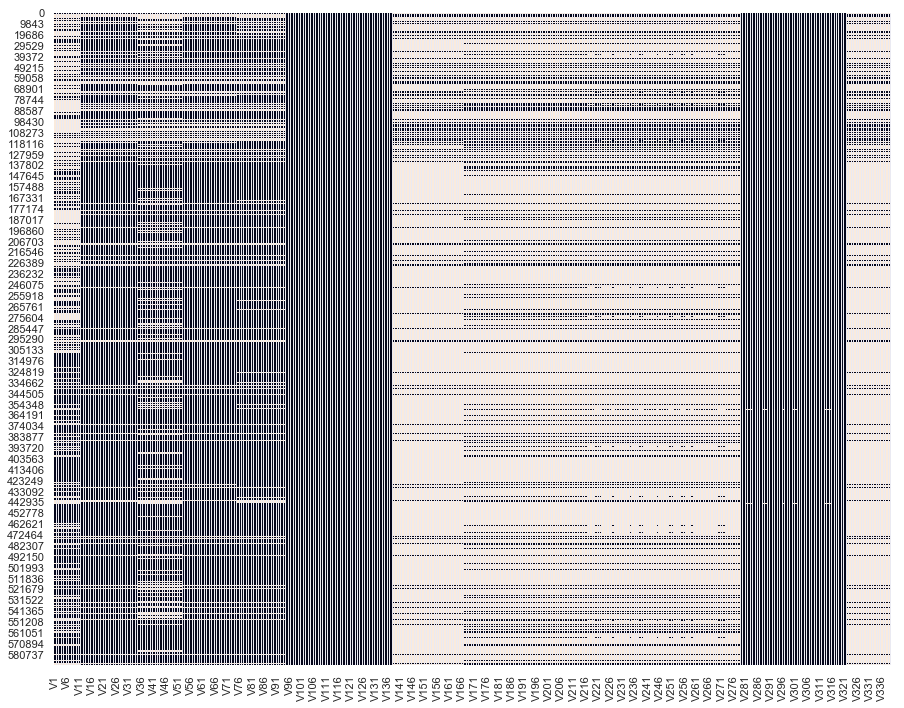

In [80]:
plt.figure(figsize=(15,12))
sns.heatmap(train.loc[:, v_features].isna(), cbar=False)
plt.show()

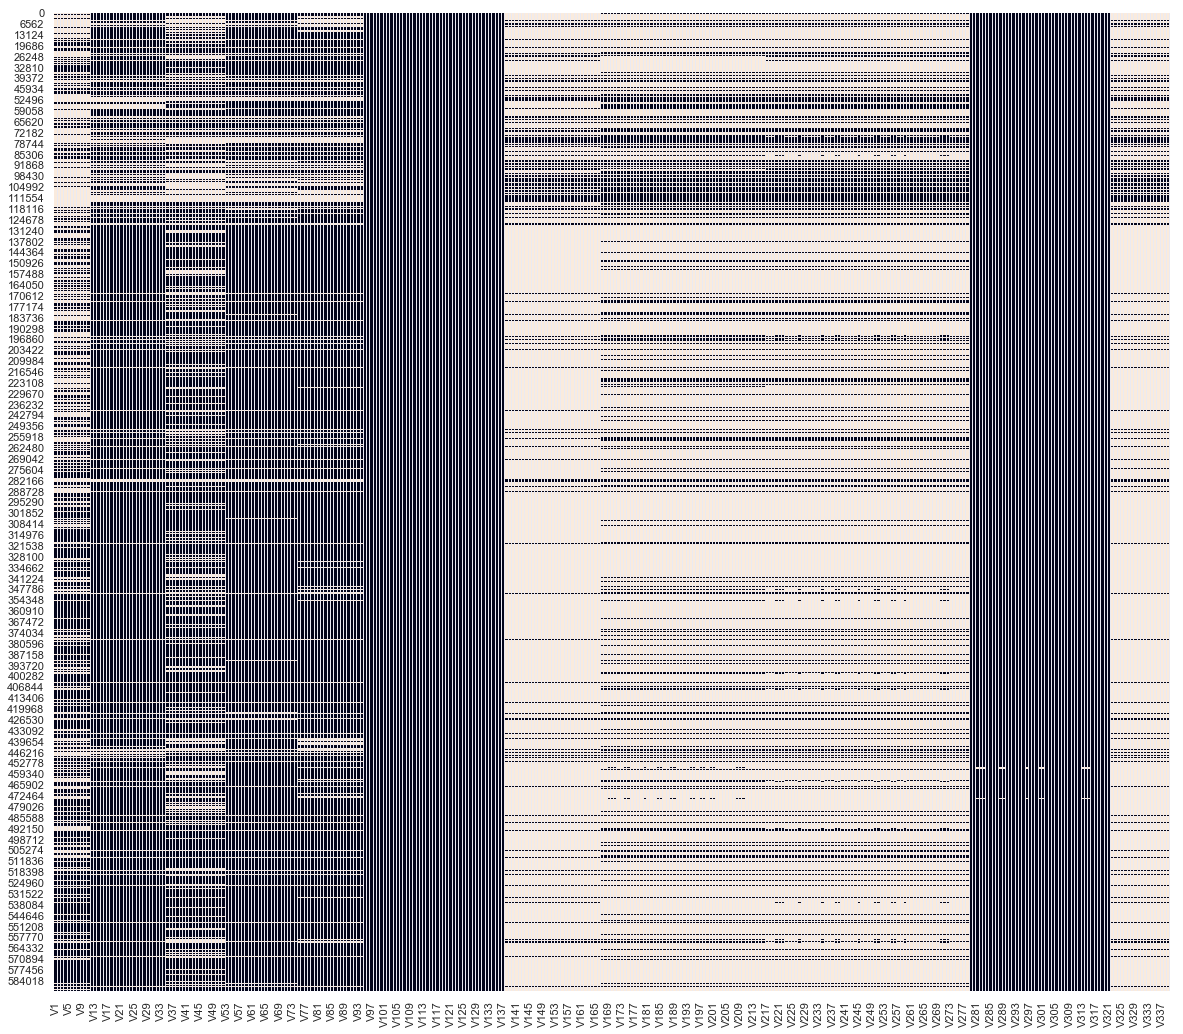

In [82]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features].isna(), cbar=False)
plt.show()

Some separate blocks of V columns that seem to all have missing values simultaneously:

- 1-13
- 13-35
- 35-53
- 53-77
- 77-95
- 95-139
- 139-167
- 167-217
- 217-281
- 281-321
- 321-337

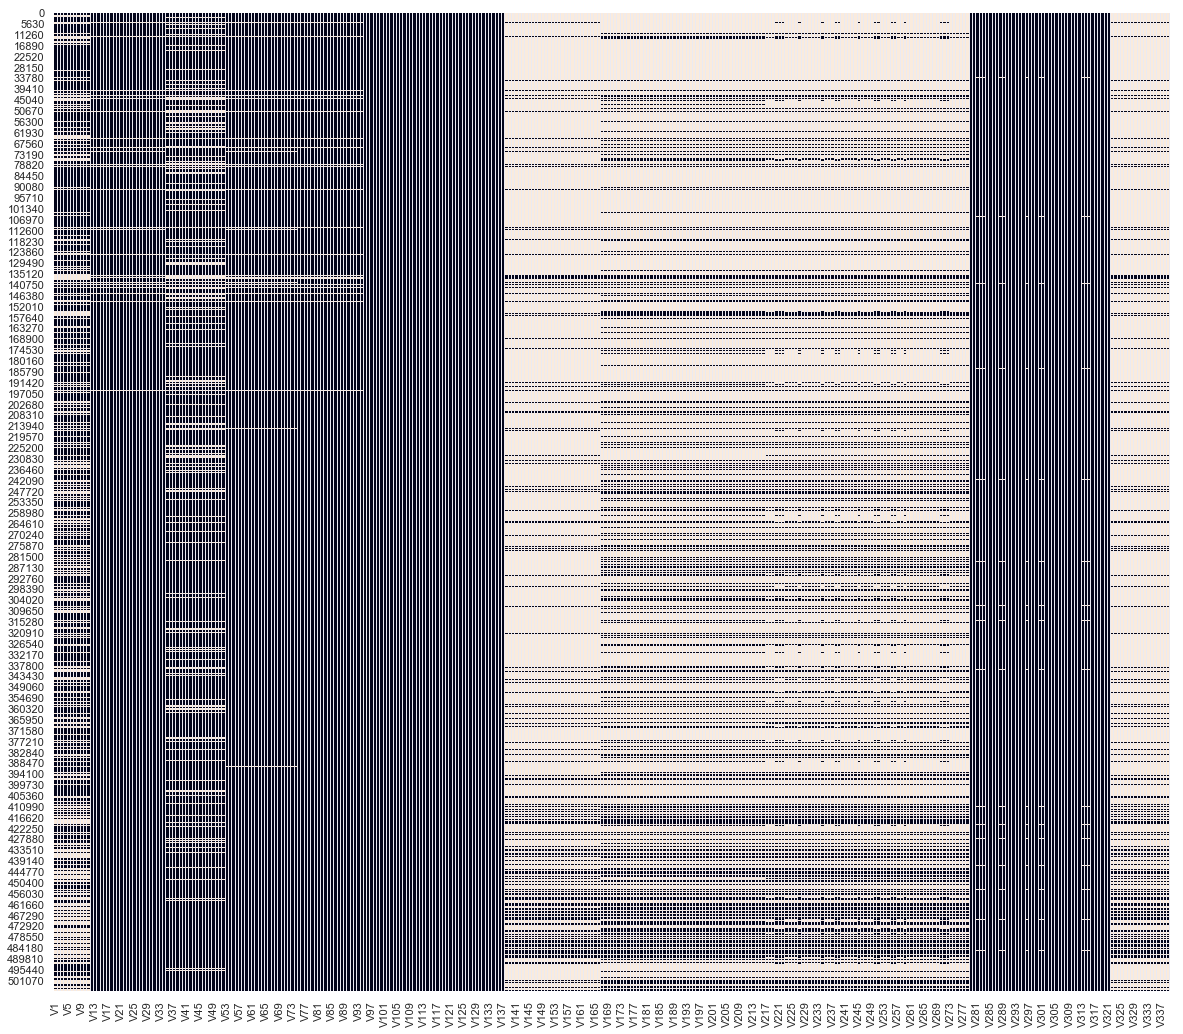

In [83]:
plt.figure(figsize=(20,18))
sns.heatmap(test.loc[:, v_features].isna(), cbar=False)
plt.show()

Similar blocks in test

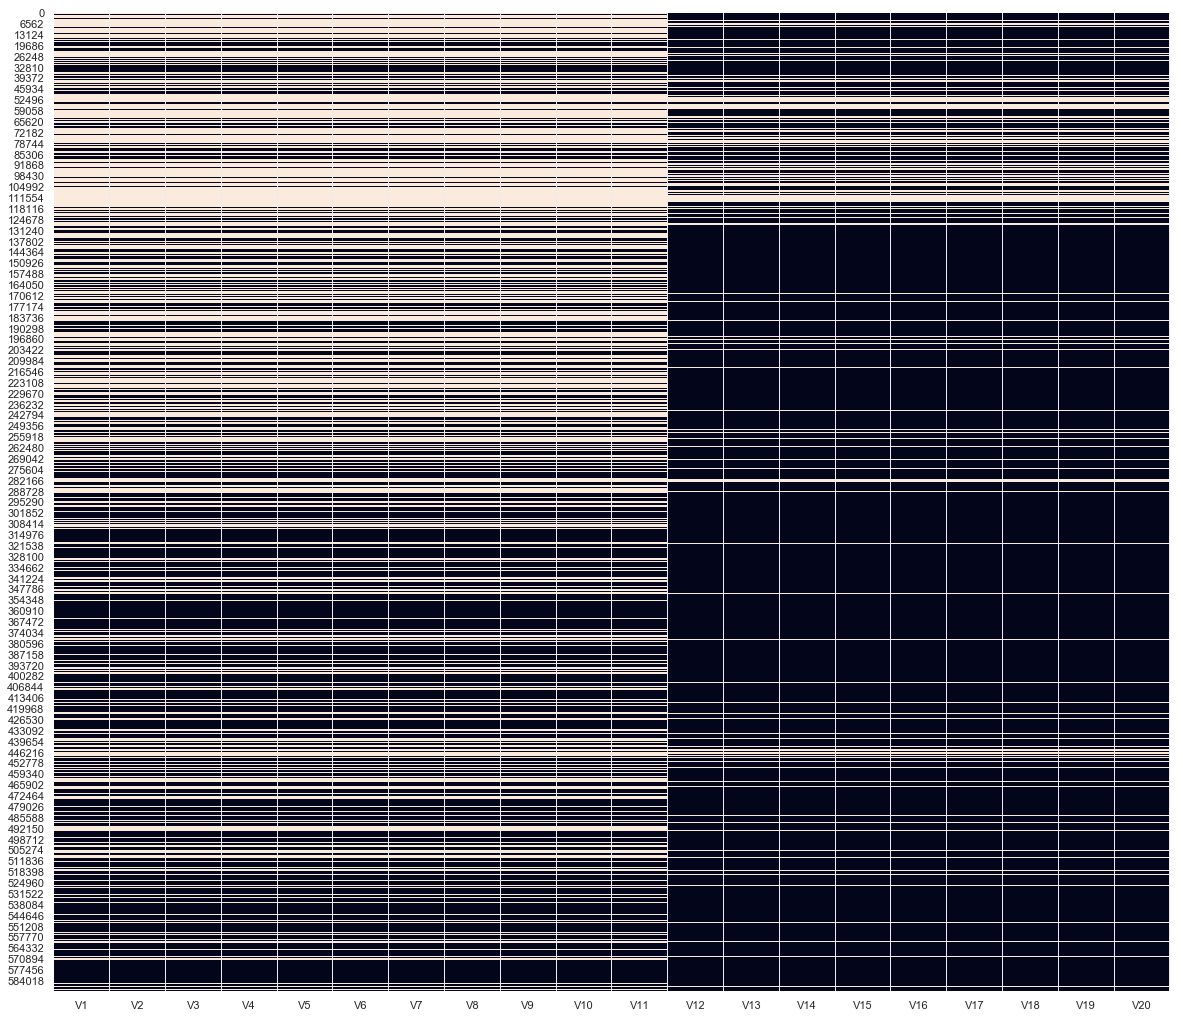

In [84]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[:20]].isna(), cbar=False)
plt.show()

In [91]:
train.loc[:, v_features[:11]].isna()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0       False  False  False  False  False  False  False  False  False  False   
1        True   True   True   True   True   True   True   True   True   True   
2       False  False  False  False  False  False  False  False  False  False   
3        True   True   True   True   True   True   True   True   True   True   
4        True   True   True   True   True   True   True   True   True   True   
5       False  False  False  False  False  False  False  False  False  False   
6       False  False  False  False  False  False  False  False  False  False   
7        True   True   True   True   True   True   True   True   True   True   
8        True   True   True   True   True   True   True   True   True   True   
9       False  False  False  False  False  False  False  False  False  False   
10       True   True   True   True   True   True   True   True   True   True   
11       True   True   True   True   True   True   True   True   True   True   
12       True   True   True   True   True   True   True   True   True   True   
13       True   True   True   True   True   True   True   True   True   True   
14       True   True   True   True   True   True   True   True   True   True   
15      False  False  False  False  False  False  False  False  False  False   
16       True   True   True   True   True   True   True   True   True   True   
17       True   True   True   True   True   True   True   True   True   True   
18      False  False  False  False  False  False  False  False  False  False   
19       True   True   True   True   True   True   True   True   True   True   
20      False  False  False  False  False  False  False  False  False  False   
21       True   True   True   True   True   True   True   True   True   True   
22       True   True   True   True   True   True   True   True   True   True   
23      False  False  False  False  False  False  False  False  False  False   
24       True   True   True   True   True   True   True   True   True   True   
25       True   True   True   True   True   True   True   True   True   True   
26       True   True   True   True   True   True   True   True   True   True   
27      False  False  False  False  False  False  False  False  False  False   
28       True   True   True   True   True   True   True   True   True   True   
29       True   True   True   True   True   True   True   True   True   True   
30       True   True   True   True   True   True   True   True   True   True   
31      False  False  False  False  False  False  False  False  False  False   
32       True   True   True   True   True   True   True   True   True   True   
33       True   True   True   True   True   True   True   True   True   True   
34      False  False  False  False  False  False  False  False  False  False   
35      False  False  False  False  False  False  False  False  False  False   
36      False  False  False  False  False  False  False  False  False  False   
37       True   True   True   True   True   True   True   True   True   True   
38       True   True   True   True   True   True   True   True   True   True   
39       True   True   True   True   True   True   True   True   True   True   
40       True   True   True   True   True   True   True   True   True   True   
41      False  False  False  False  False  False  False  False  False  False   
42      False  False  False  False  False  False  False  False  False  False   
43      False  False  False  False  False  False  False  False  False  False   
44       True   True   True   True   True   True   True   True   True   True   
45      False  False  False  False  False  False  False  False  False  False   
46      False  False  False  False  False  False  False  False  False  False   
47       True   True   True   True   True   True   True   True   True   True   
48       True   True   True   True   True   True   True   True   True   True   
49       Tr

In [94]:
train.loc[:, v_features[:11]].head().isna().all(axis=1) == False

0     True
1    False
2     True
3    False
4    False
dtype: bool

In [133]:
train['HasV1toV11'] = train.loc[:, v_features[:11]].isna().all(axis=1) == False
test['HasV1toV11'] = test.loc[:, v_features[:11]].isna().all(axis=1) == False

Some separate blocks of V columns that seem to all have missing values simultaneously:

- 1-13
- 13-35
- 35-53
- 53-77
- 77-95
- 95-139
- 139-167
- 167-217
- 217-281
- 281-321
- 321-337

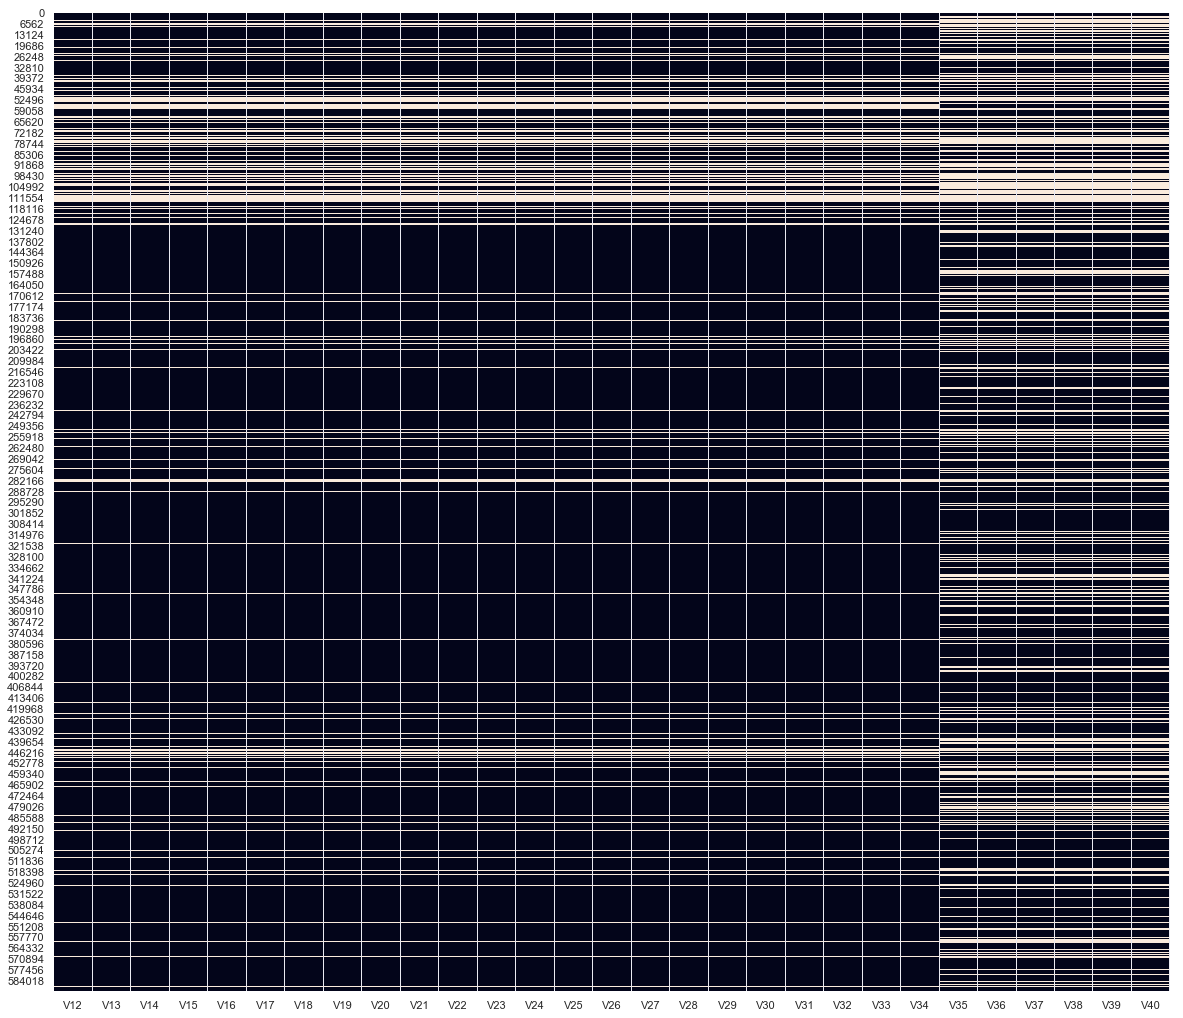

In [97]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[11:40]].isna(), cbar=False)
plt.show()

In [99]:
train.loc[:, v_features[11:34]].head()

V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V27  V28  V29  V30  V31  V32  V33  V34  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [134]:
train['HasV12toV34'] = train.loc[:, v_features[11:34]].isna().all(axis=1) == False
test['HasV12toV34'] = test.loc[:, v_features[11:34]].isna().all(axis=1) == False

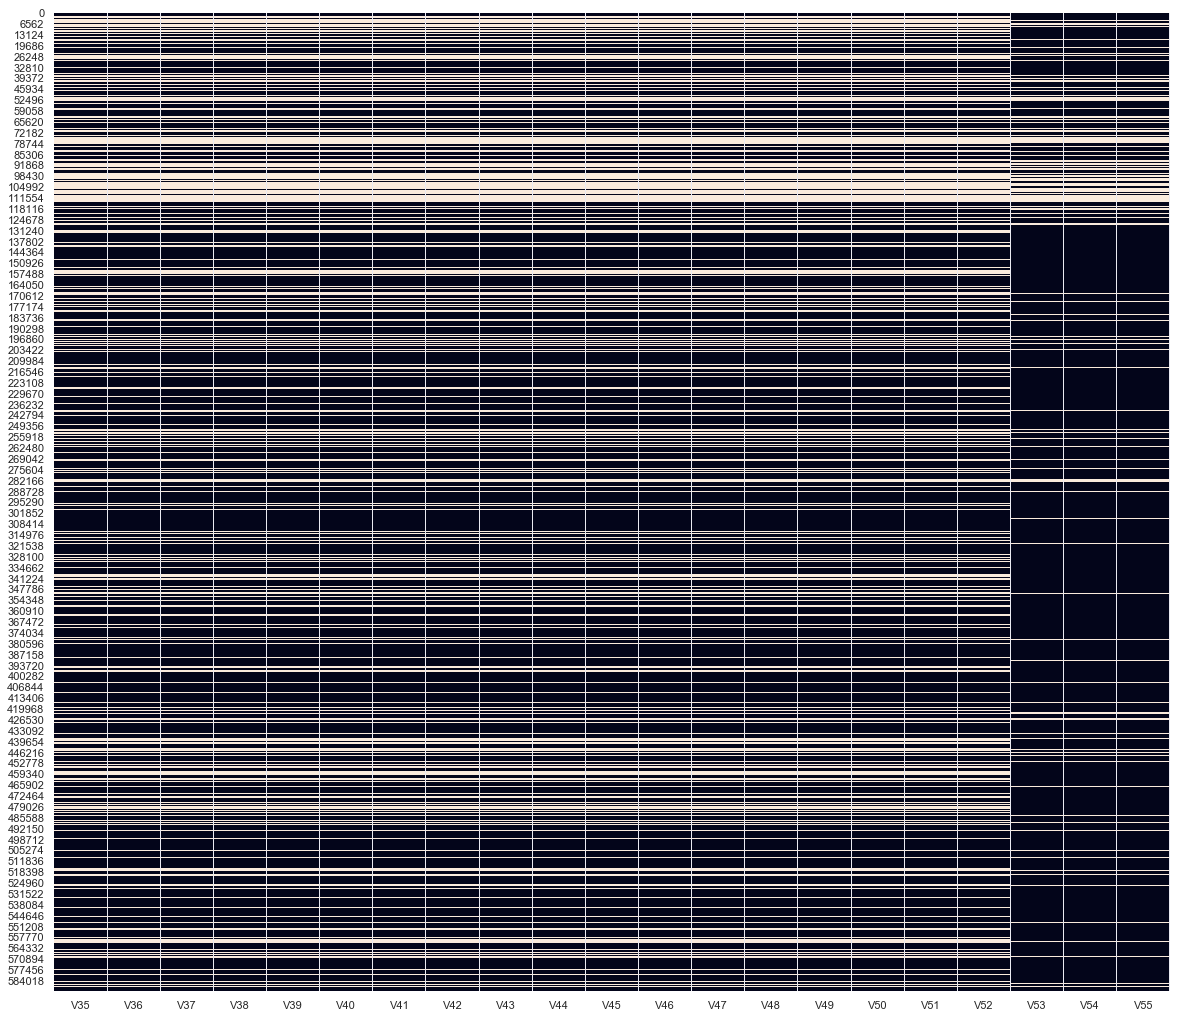

In [101]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[34:55]].isna(), cbar=False)
plt.show()

In [135]:
train['HasV35toV52'] = train.loc[:, v_features[34:52]].isna().all(axis=1) == False
test['HasV35toV52'] = test.loc[:, v_features[34:52]].isna().all(axis=1) == False

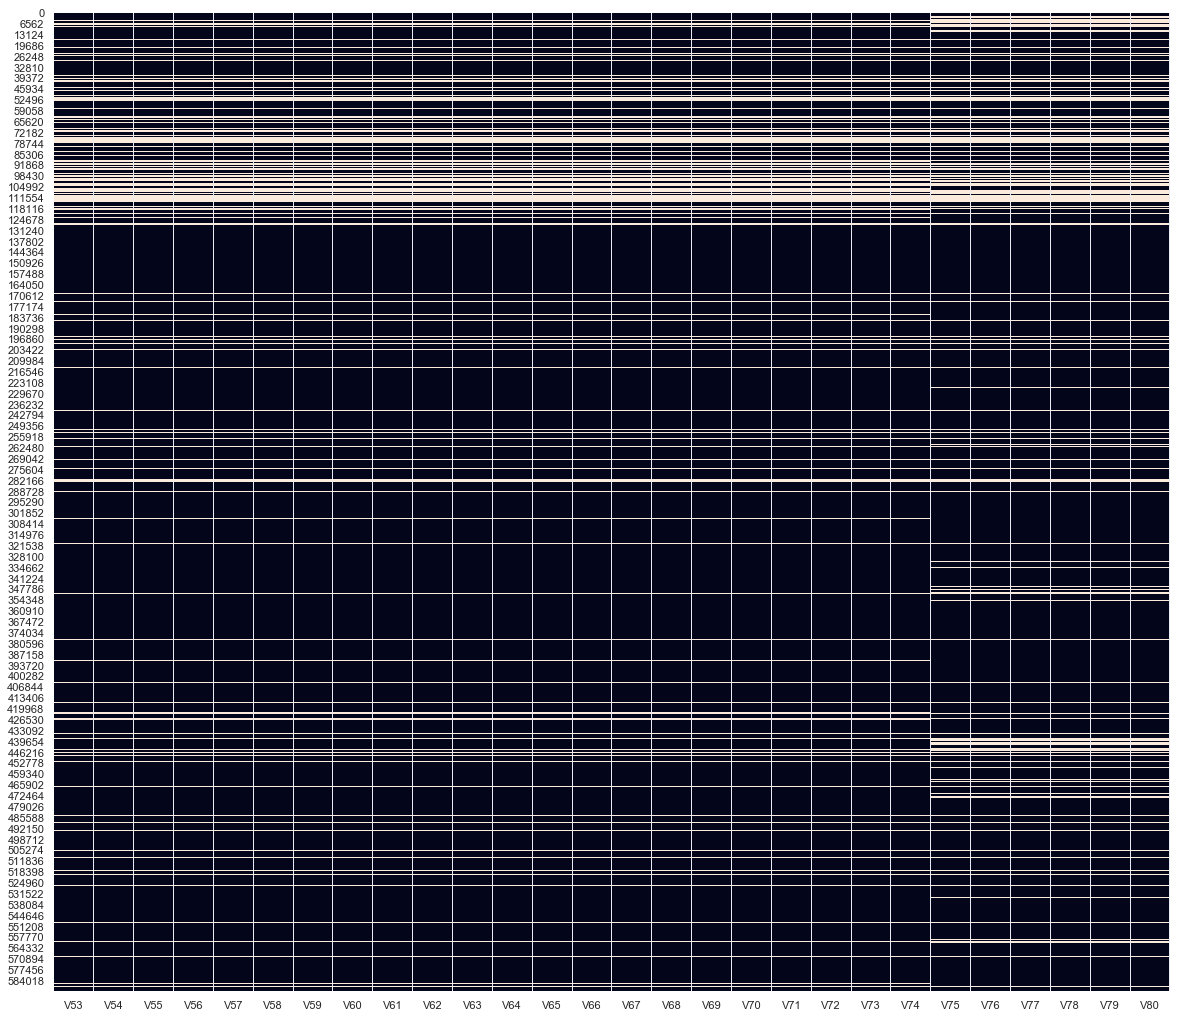

In [103]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[52:80]].isna(), cbar=False)
plt.show()

In [136]:
train['HasV53toV74'] = train.loc[:, v_features[52:74]].isna().all(axis=1) == False
test['HasV53toV74'] = test.loc[:, v_features[52:74]].isna().all(axis=1) == False

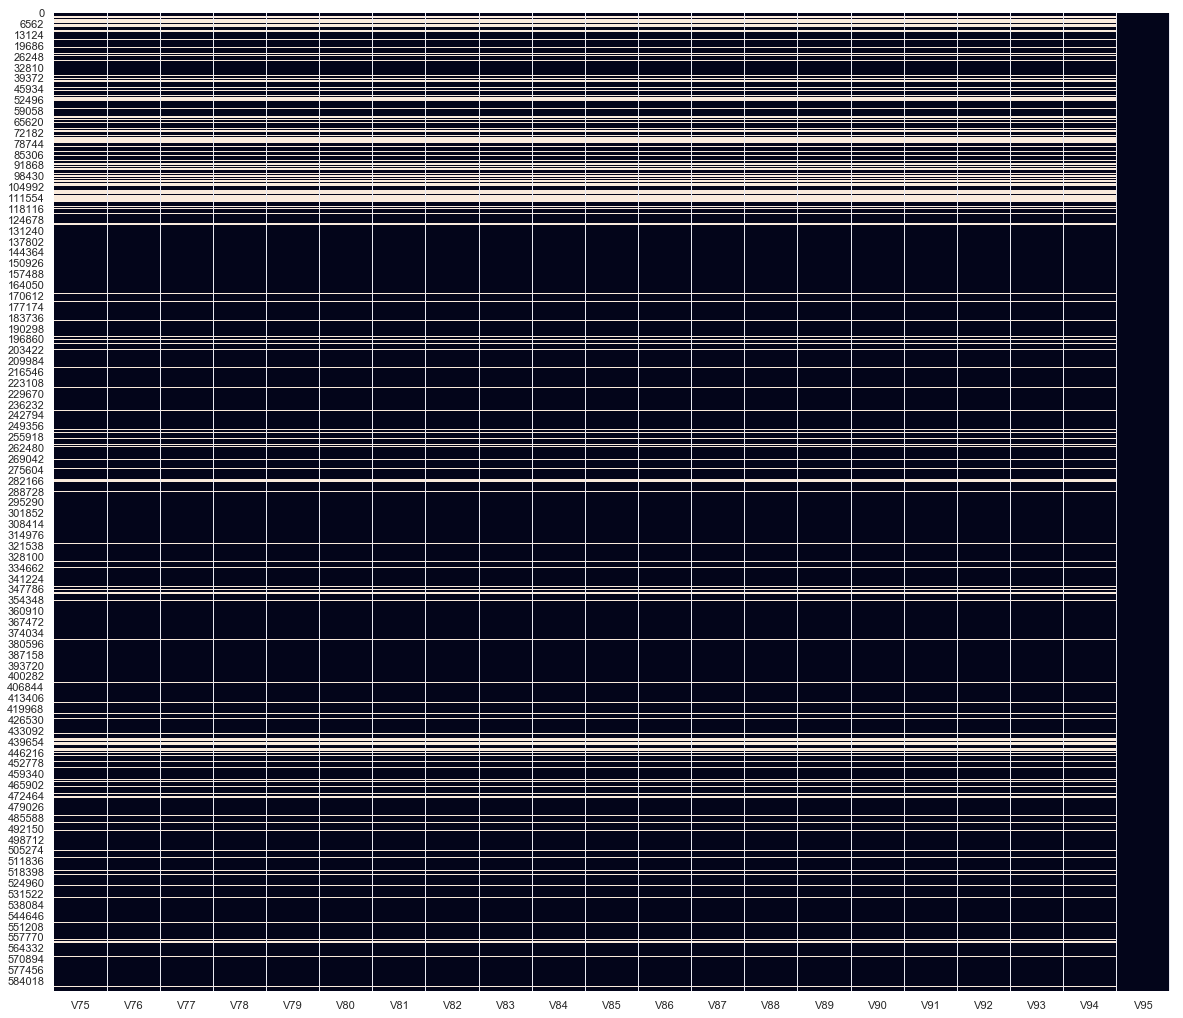

In [105]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[74:95]].isna(), cbar=False)
plt.show()

In [137]:
train['HasV75toV94'] = train.loc[:, v_features[74:94]].isna().all(axis=1) == False
test['HasV75toV94'] = test.loc[:, v_features[74:94]].isna().all(axis=1) == False

In [113]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

In [108]:
train.loc[:, v_features[74:94]].head()

V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  \
0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0   
1  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
2  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
3  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V90  V91  V92  V93  V94  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  NaN  NaN  NaN  NaN  NaN

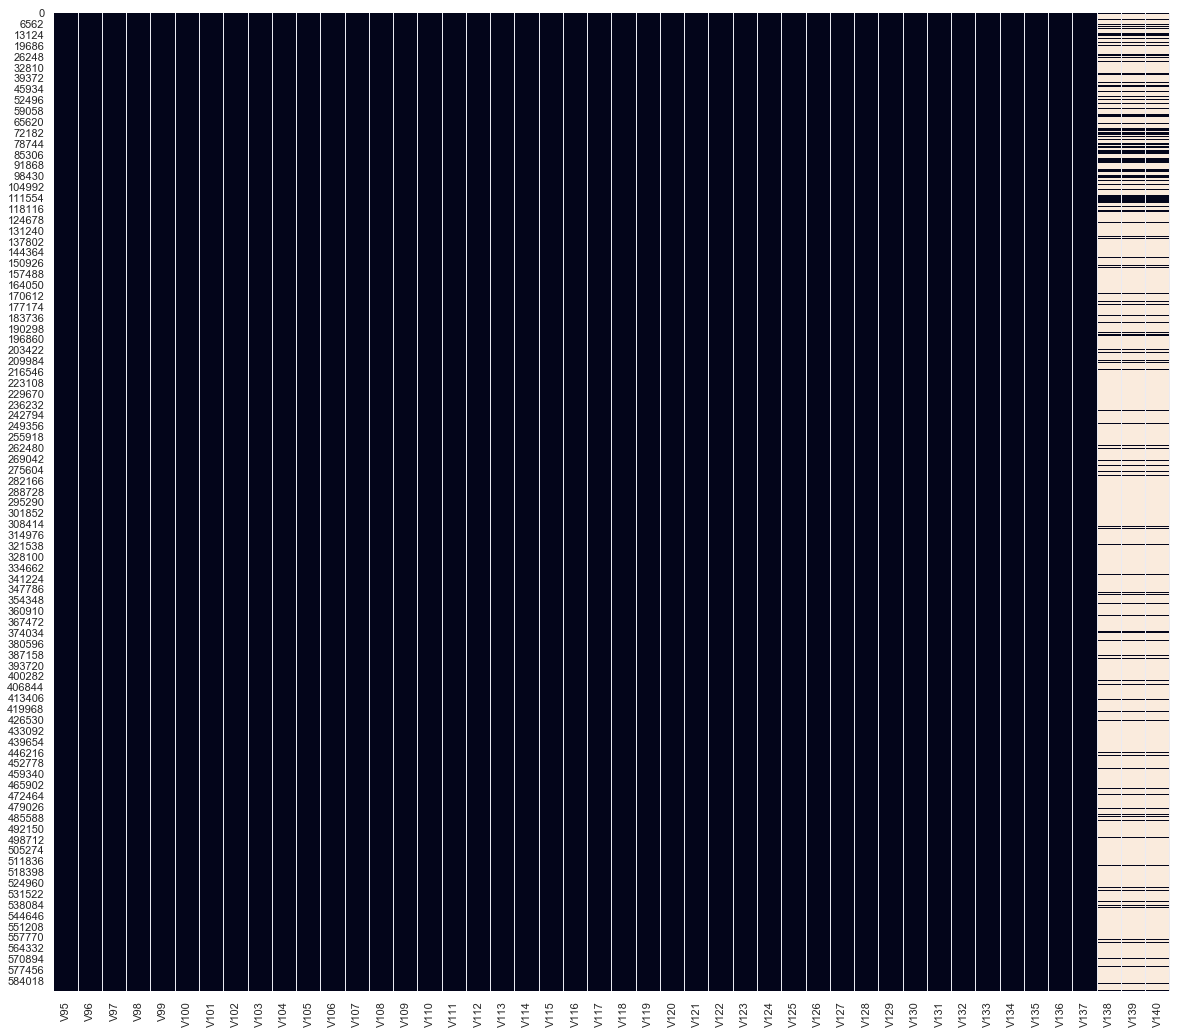

In [110]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[94:140]].isna(), cbar=False)
plt.show()

In [138]:
train['HasV95toV137'] = train.loc[:, v_features[94:137]].isna().all(axis=1) == False
test['HasV95toV137'] = test.loc[:, v_features[94:137]].isna().all(axis=1) == False

In [115]:
train.loc[:, v_features[94:137]].head()

V95   V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   
1  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
2  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
3  1.0  48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   
4  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V120  V121  V122  V123  V124  V125  V126    V127   V128  V129   V130  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0    0.0   0.0    0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   0.0    0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   0.0    0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0  50.0  1758.0  925.0   0.0  354.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   0.0    0.0   

    V131  V132    V133   V134  V135  V136  V137  
0    0.0   0.0   117.0    0.0   0.0   0.0   0.0  
1    0.0   0.0     0.0    0.0   0.0   0.0   0.0  
2    0.0   0.0     0.0    0.0   0.0   0.0   0.0  
3  135.0  50.0  1404.0  790.0   0.0   0.0   0.0  
4    0.0   0.0     0.0    0.0   0.0   0.0   0.0

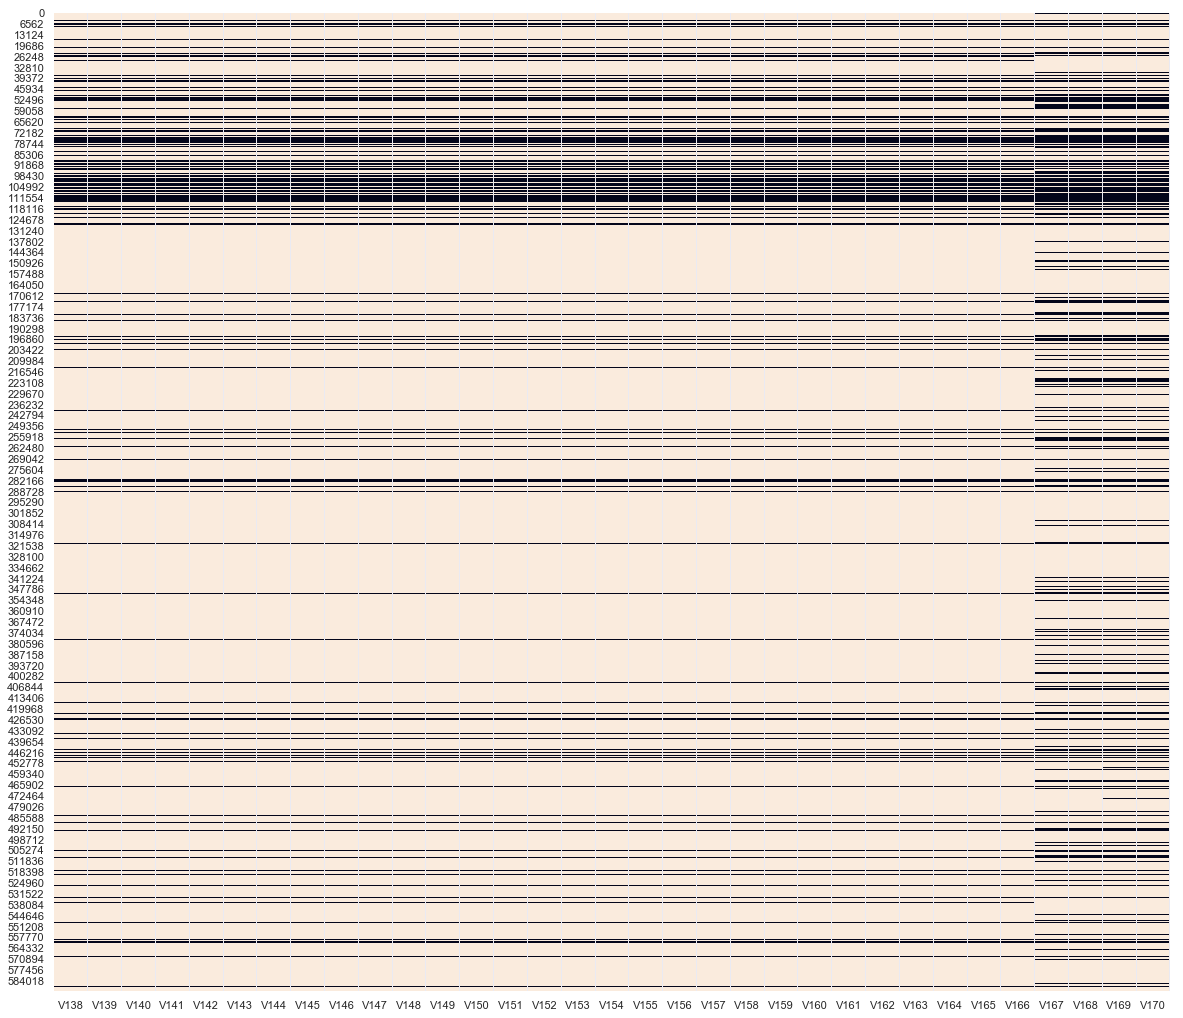

In [116]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[137:170]].isna(), cbar=False)
plt.show()

In [139]:
train['HasV138toV166'] = train.loc[:, v_features[137:166]].isna().all(axis=1) == False
test['HasV138toV166'] = test.loc[:, v_features[137:166]].isna().all(axis=1) == False

In [117]:
train.loc[:, v_features[137:166]].head()

V138  V139  V140  V141  V142  V143  V144   V145  V146  V147  V148  V149  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   0.0   0.0   6.0  18.0  140.0   0.0   0.0   0.0   0.0   

     V150  V151  V152  V153  V154  V155  V156  V157  V158          V159  \
0     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN   
1     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN   
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN   
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN   
4  1803.0  49.0  64.0   0.0   0.0   0.0   0.0   0.0   0.0  15557.990234   

            V160  V161  V162  V163   V164    V165    V166  
0            NaN   NaN   NaN   NaN    NaN     NaN     NaN  
1            NaN   NaN   NaN   NaN    NaN     NaN     NaN  
2            NaN   NaN   NaN   NaN    NaN     NaN     NaN  
3            NaN   NaN   NaN   NaN    NaN     NaN     NaN  
4  169690.796875   0.0   0.0   0.0  515.0  5155.0  2840.0

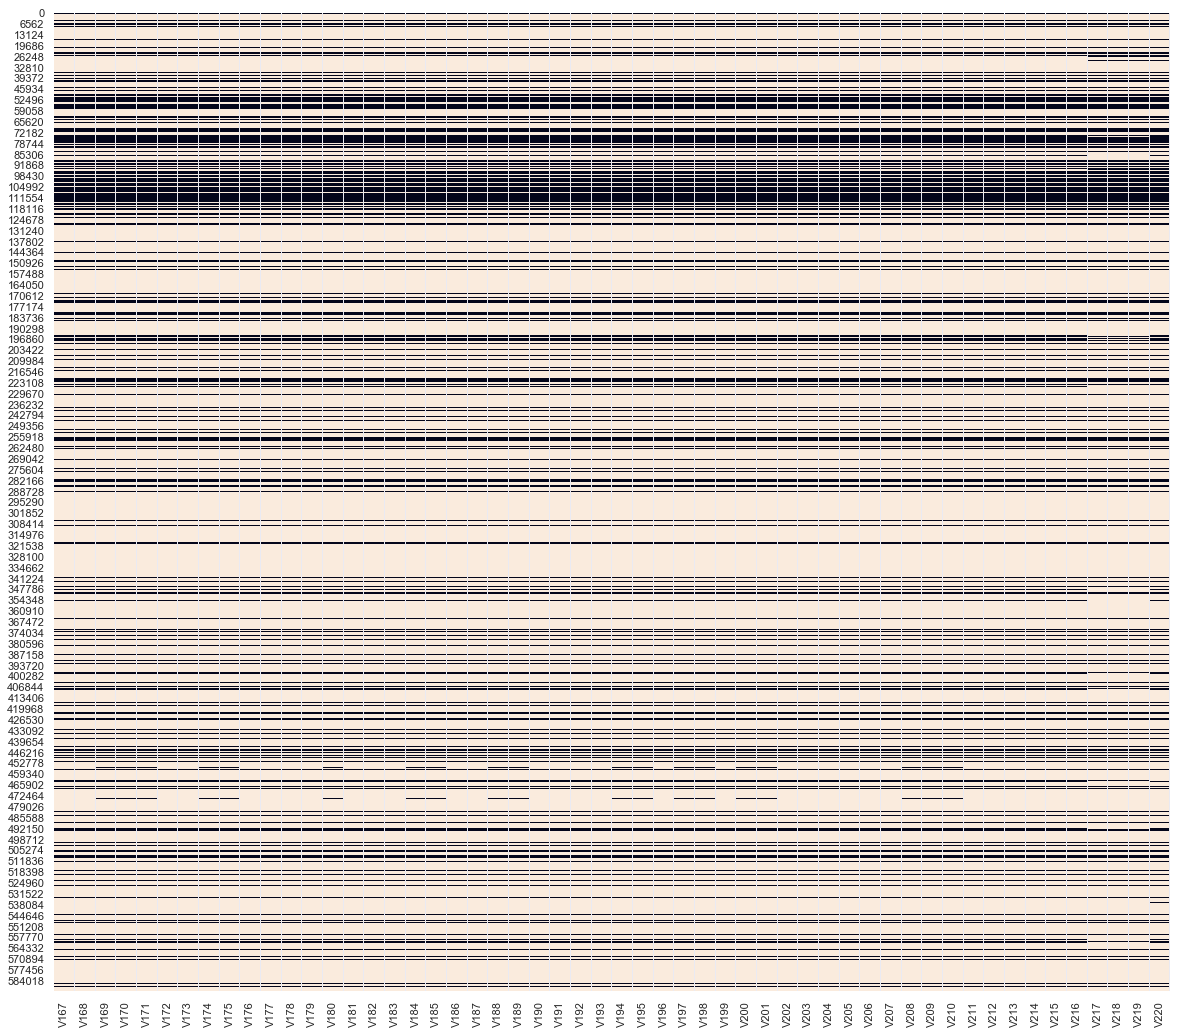

In [119]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[166:220]].isna(), cbar=False)
plt.show()

In [140]:
train['HasV167toV216'] = train.loc[:, v_features[166:216]].isna().all(axis=1) == False
test['HasV167toV216'] = test.loc[:, v_features[166:216]].isna().all(axis=1) == False

In [120]:
train.loc[:, v_features[166:216]].head()

V167  V168  V169  V170  V171  V172  V173  V174  V175  V176  V177  V178  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   

   V179  V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V190  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   

   V191  V192  V193  V194  V195  V196  V197  V198  V199  V200  V201  V202  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   

   V203  V204  V205  V206  V207  V208  V209  V210  V211  V212  V213  V214  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V215  V216  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   0.0   0.0

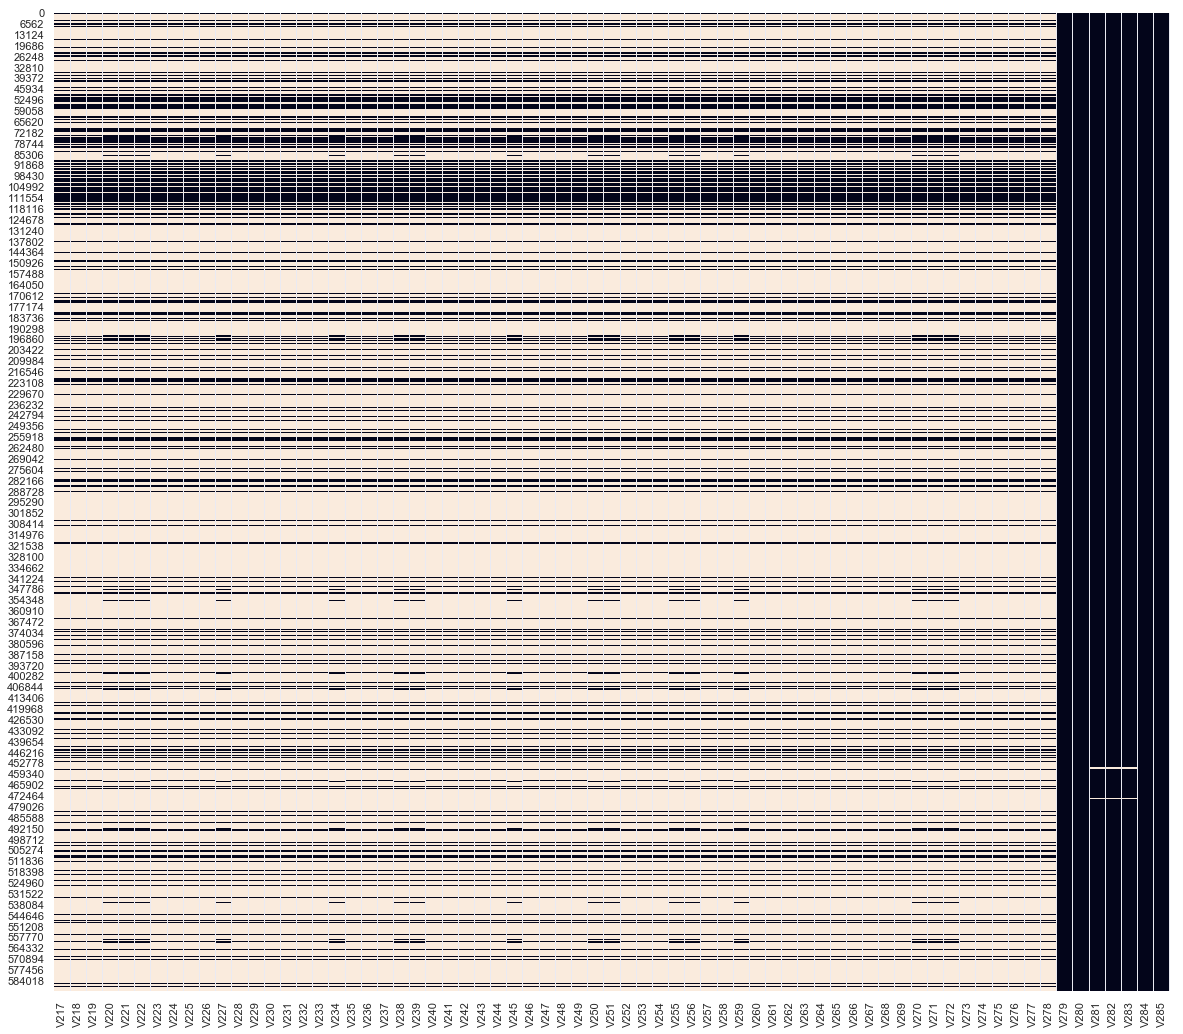

In [123]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[216:285]].isna(), cbar=False)
plt.show()

In [141]:
train['HasV217toV278'] = train.loc[:, v_features[216:278]].isna().all(axis=1) == False
test['HasV217toV278'] = test.loc[:, v_features[216:278]].isna().all(axis=1) == False

In [124]:
train.loc[:, v_features[216:278]].head()

V217  V218  V219  V220  V221  V222  V223  V224  V225  V226  V227  V228  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   

   V229  V230  V231  V232  V233  V234  V235  V236  V237  V238  V239  V240  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   V241  V242  V243  V244  V245  V246  V247  V248  V249  V250  V251  V252  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V253  V254  V255  V256  V257  V258  V259  V260  V261  V262  V263  V264  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   0.0   

   V265  V266  V267  V268  V269  V270  V271  V272  V273  V274  V275  V276  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V277  V278  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   0.0   0.0

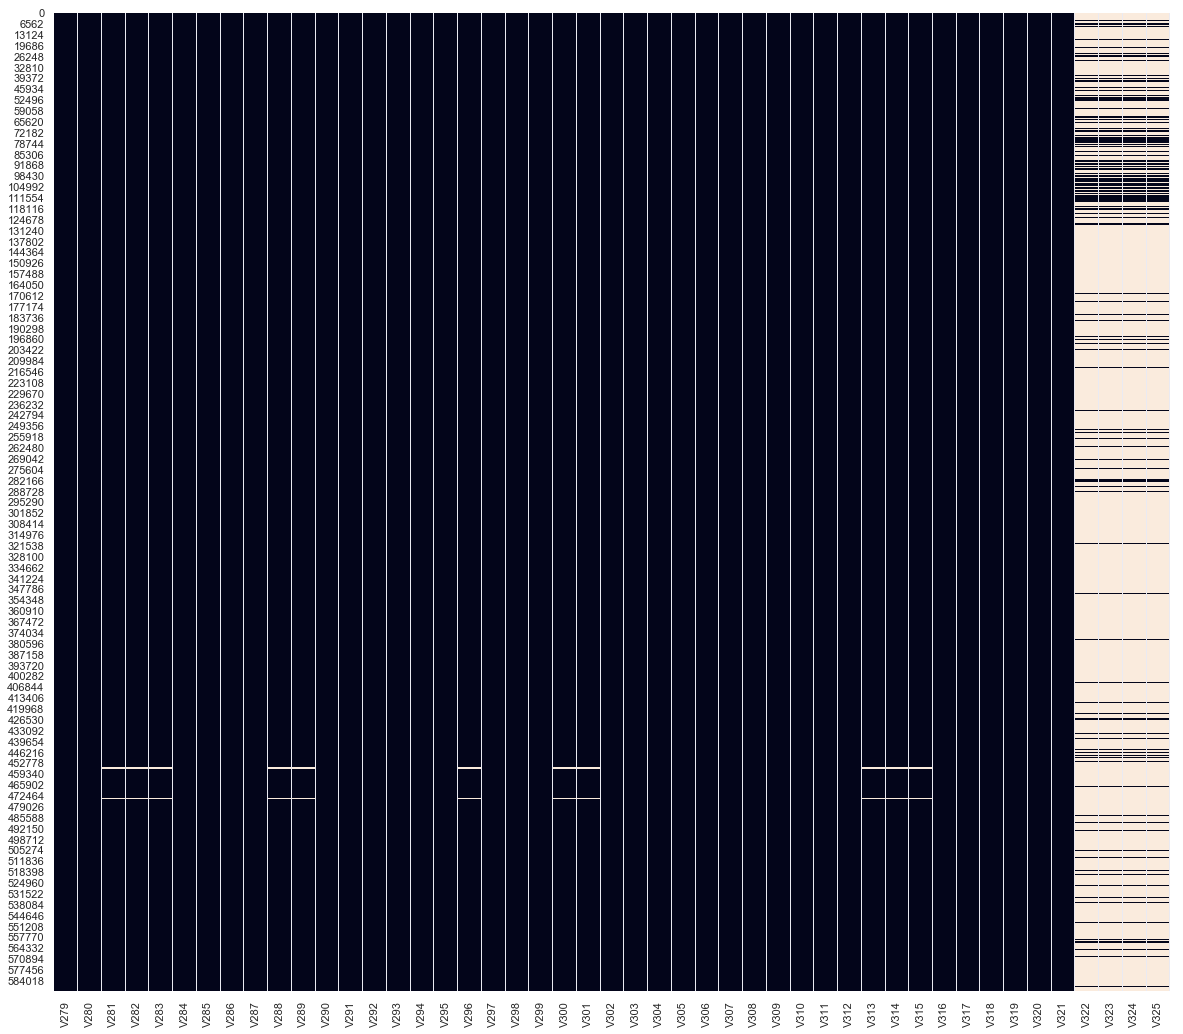

In [126]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[278:325]].isna(), cbar=False)
plt.show()

In [142]:
train['HasV279toV321'] = train.loc[:, v_features[278:321]].isna().all(axis=1) == False
test['HasV279toV321'] = test.loc[:, v_features[278:321]].isna().all(axis=1) == False

In [127]:
train.loc[:, v_features[278:321]].head()

V279  V280  V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  \
0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
1   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
2   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
3   1.0  28.0   0.0   0.0   0.0   0.0  10.0   0.0   4.0   0.0   0.0   1.0   
4   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   V291  V292  V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  \
0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   1.0   1.0   1.0  38.0  24.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   V303  V304  V305  V306    V307   V308  V309   V310  V311   V312  V313  \
0   0.0   0.0   1.0   0.0   117.0    0.0   0.0    0.0   0.0    0.0   0.0   
1   0.0   0.0   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   
2   0.0   0.0   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   
3   0.0   0.0   1.0  50.0  1758.0  925.0   0.0  354.0   0.0  135.0   0.0   
4   1.0   1.0   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   

   V314  V315  V316    V317   V318  V319  V320  V321  
0   0.0   0.0   0.0   117.0    0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0     0.0    0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0     0.0    0.0   0.0   0.0   0.0  
3   0.0   0.0  50.0  1404.0  790.0   0.0   0.0   0.0  
4   0.0   0.0   0.0     0.0    0.0   0.0   0.0   0.0

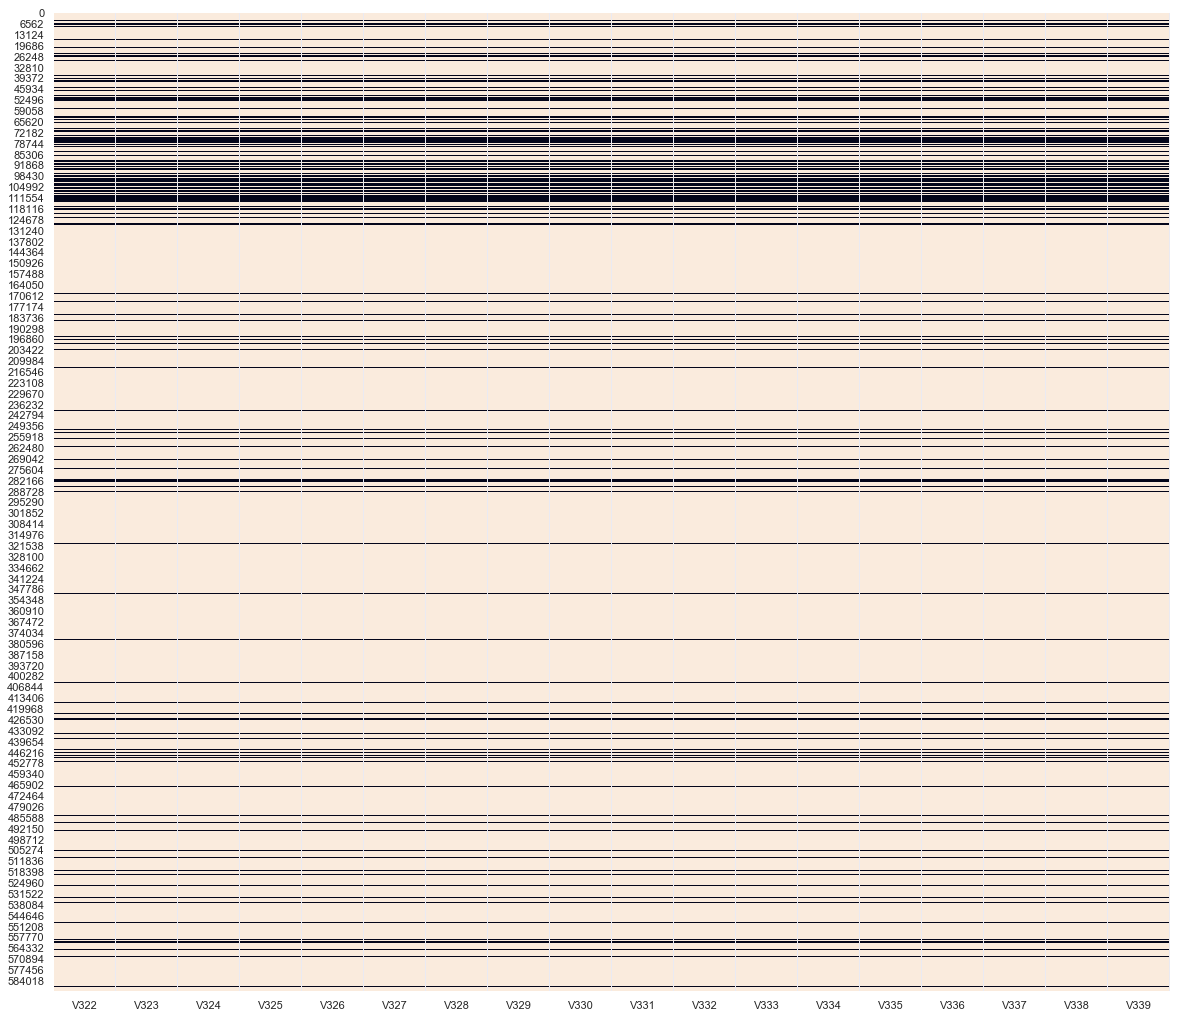

In [129]:
plt.figure(figsize=(20,18))
sns.heatmap(train.loc[:, v_features[321:]].isna(), cbar=False)
plt.show()

In [143]:
train['HasV322toV339'] = train.loc[:, v_features[321:]].isna().all(axis=1) == False
test['HasV322toV339'] = test.loc[:, v_features[321:]].isna().all(axis=1) == False

In [132]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

In [144]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  addr1 addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0  87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0  87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0  87.0  2635.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0  87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0  87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0 

# Splitting into train, val, and test

In [145]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [146]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [147]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [148]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [149]:
X_train.shape

(583369, 443)

In [150]:
X_val.shape

(7171, 443)

In [151]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [152]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [153]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [154]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994996	valid_1's auc: 0.973697
[100]	training's auc: 0.999338	valid_1's auc: 0.978038
[150]	training's auc: 0.999883	valid_1's auc: 0.979083
[200]	training's auc: 0.999981	valid_1's auc: 0.979408
[250]	training's auc: 0.999996	valid_1's auc: 0.980805
[300]	training's auc: 0.999999	valid_1's auc: 0.981115
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.999999	valid_1's auc: 0.981115


# Predict on test sets

In [155]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [156]:
sub_preds

array([8.54197312e-06, 1.31860391e-04, 6.18818808e-06, ...,
       4.00661747e-04, 7.01587572e-05, 4.58970729e-05])

In [157]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9811151316774629


# Bootstrapping

In [158]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

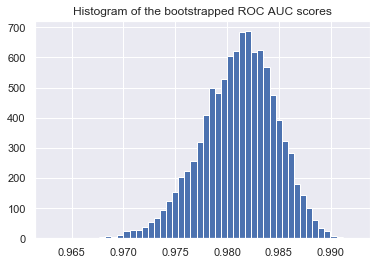

In [159]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [160]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.975 - 0.987]


In [161]:
sorted_scores.mean()

0.9810894469534412

In [162]:
sorted_scores.std()

0.0036200598281590267

# Save submission predictions

In [163]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_HasVfeats2.csv', index=False)

# Feature importances

In [164]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [165]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [166]:
feature_importance_df.head()

feature  importance
2             card1       10642
0    TransactionAmt        9129
8             addr1        4560
10            dist1        4522
431     card1_count        4104

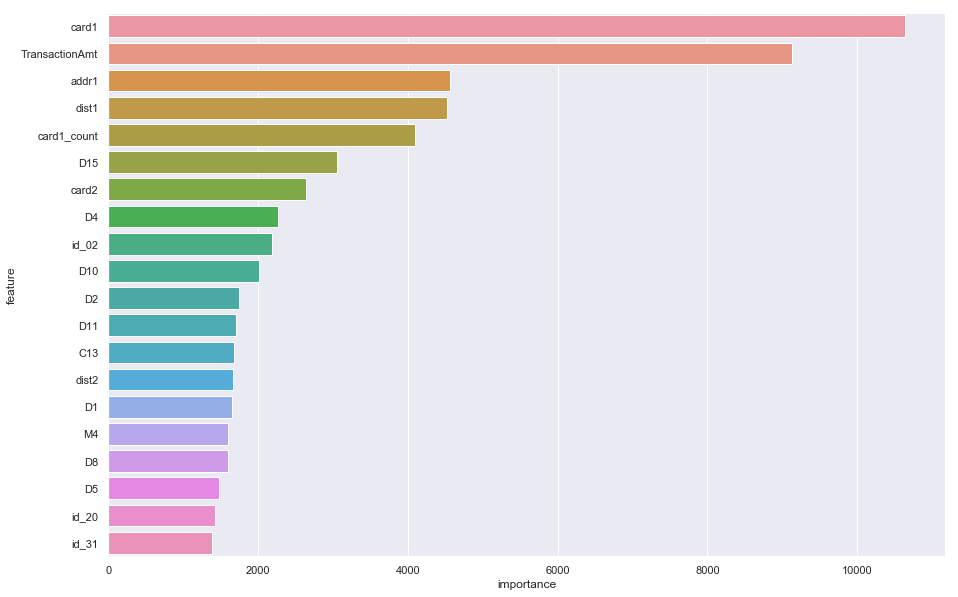

In [167]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [168]:
feature_importance_df

feature  importance
2             card1       10642
0    TransactionAmt        9129
8             addr1        4560
10            dist1        4522
431     card1_count        4104
42              D15        3060
3             card2        2649
31               D4        2263
392           id_02        2183
37              D10        2016
29               D2        1750
38              D11        1710
26              C13        1681
11            dist2        1674
28               D1        1660
46               M4        1607
35               D8        1607
32               D5        1482
410           id_20        1425
421           id_31        1386
30               D3        1210
12    P_emaildomain        1195
395           id_05        1162
409           id_19        1159
14               C1        1114
48               M6        1019
15               C2         993
430      DeviceInfo         945
396           id_06         933
41              D14         908
47               M5         887
19               C6         869
391           id_01         856
50               M8         851
51               M9         814
24              C11         768
36               D9         757
27              C14         731
49               M7         729
364            V313         702
22               C9         658
45               M3         585
18               C5         496
358            V307         491
33               D6         491
134             V83         460
44               M2         458
39              D12         451
361            V310         428
138             V87         417
..              ...         ...
206            V155           4
381            V330           4
248            V197           4
380            V329           4
204            V153           3
379            V328           3
163            V112           3
193            V142           3
197            V146           3
378            V327           2
164            V113           2
320            V269           2
416           id_26           2
417           id_27           2
9             addr2           2
249            V198           2
172            V121           1
173            V122           1
376            V325           1
437    HasV95toV137           0
436     HasV75toV94           0
438   HasV138toV166           0
441   HasV279toV321           0
439   HasV167toV216           0
435     HasV53toV74           0
52               V1           0
440   HasV217toV278           0
433     HasV12toV34           0
432      HasV1toV11           0
5             card4           0
434     HasV35toV52           0
171            V120           0
65              V14           0
414           id_24           0
170            V119           0
169            V118           0
168            V117           0
158            V107           0
303            V252           0
356            V305           0
292            V241           0
140             V89           0
139             V88           0
119             V68           0
116             V65           0
92              V41           0
79              V28           0
78              V27           0
412           id_22           0
442   HasV322toV339           0

[443 rows x 2 columns]

# Dropping all V features and only keeping encoded features

In [169]:
train = train.drop(v_features, axis=1)
test = test.drop(v_features, axis=1)

# Splitting into train, val, and test

In [170]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [171]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [172]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [173]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [174]:
X_train.shape

(583369, 104)

In [175]:
X_val.shape

(7171, 104)

In [176]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [177]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [178]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [179]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994505	valid_1's auc: 0.970028
[100]	training's auc: 0.999213	valid_1's auc: 0.976304
[150]	training's auc: 0.999867	valid_1's auc: 0.978071
[200]	training's auc: 0.999976	valid_1's auc: 0.97779
Early stopping, best iteration is:
[159]	training's auc: 0.999903	valid_1's auc: 0.978657


# Predict on test sets

In [180]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [181]:
sub_preds

array([4.03899285e-05, 2.45708883e-04, 5.50874107e-05, ...,
       8.91839548e-04, 8.12929204e-04, 7.10369992e-04])

In [182]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9786566943310602


# Bootstrapping

In [183]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

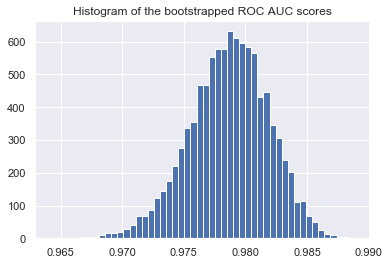

In [184]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [185]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.973 - 0.984]


In [186]:
sorted_scores.mean()

0.978642862422074

In [187]:
sorted_scores.std()

0.0032117217241216414

# Save submission predictions

In [188]:
sub_df['isFraud'] = sub_preds
# sub_df.to_csv('../submissions/submission_HasVfeats2.csv', index=False)

# Feature importances

In [189]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [190]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [191]:
feature_importance_df.head()

feature  importance
2            card1        6379
0   TransactionAmt        5413
8            addr1        3646
92     card1_count        2929
10           dist1        2643

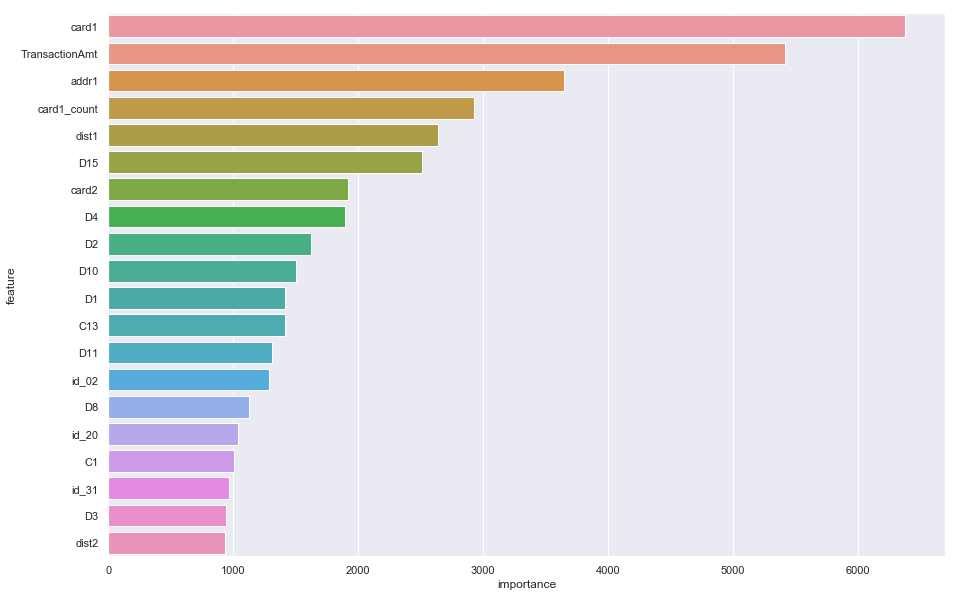

In [192]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [193]:
feature_importance_df

feature  importance
2             card1        6379
0    TransactionAmt        5413
8             addr1        3646
92      card1_count        2929
10            dist1        2643
42              D15        2509
3             card2        1921
31               D4        1899
29               D2        1627
37              D10        1500
28               D1        1414
26              C13        1412
38              D11        1309
53            id_02        1289
35               D8        1129
71            id_20        1036
14               C1        1007
82            id_31         969
30               D3         943
11            dist2         935
46               M4         929
15               C2         924
70            id_19         882
12    P_emaildomain         852
32               D5         821
19               C6         815
48               M6         750
91       DeviceInfo         658
27              C14         639
56            id_05         632
47               M5         628
57            id_06         615
24              C11         588
41              D14         557
52            id_01         548
36               D9         544
22               C9         536
50               M8         487
18               C5         447
33               D6         405
51               M9         375
49               M7         344
45               M3         319
39              D12         287
40              D13         281
21               C8         277
81            id_30         273
44               M2         238
25              C12         237
23              C10         200
..              ...         ...
6             card5         156
84            id_33         154
60            id_09         135
90       DeviceType         115
64            id_13         104
66            id_15          99
54            id_03          96
62            id_11          84
20               C7          68
63            id_12          66
4             card3          64
96      HasV53toV74          63
88            id_37          61
58            id_07          49
85            id_34          37
1         ProductCD          37
59            id_08          33
87            id_36          32
83            id_32          32
16               C3          26
43               M1          24
67            id_16          21
72            id_21          21
55            id_04          19
7             card6          16
79            id_28          16
86            id_35          12
61            id_10          10
74            id_23           7
76            id_25           6
65            id_14           6
80            id_29           5
101   HasV217toV278           4
69            id_18           3
77            id_26           2
98     HasV95toV137           2
100   HasV167toV216           2
95      HasV35toV52           1
99    HasV138toV166           1
78            id_27           0
75            id_24           0
5             card4           0
73            id_22           0
93       HasV1toV11           0
94      HasV12toV34           0
9             addr2           0
97      HasV75toV94           0
68            id_17           0
102   HasV279toV321           0
103   HasV322toV339           0

[104 rows x 2 columns]

In [195]:
feature_importance_df[feature_importance_df.feature.isin([feature for feature in feature_importance_df.feature if feature.startswith('HasV')])]

feature  importance
96     HasV53toV74          63
101  HasV217toV278           4
98    HasV95toV137           2
100  HasV167toV216           2
95     HasV35toV52           1
99   HasV138toV166           1
93      HasV1toV11           0
94     HasV12toV34           0
97     HasV75toV94           0
102  HasV279toV321           0
103  HasV322toV339           0

# Keeping only HasV53toV74 and no other V features

In [199]:
train = pd.read_csv('../output/train_card1_count.csv')
test = pd.read_csv('../output/test_card1_count.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [200]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [201]:
train['HasV53toV74'] = train.loc[:, v_features[52:74]].isna().all(axis=1) == False
test['HasV53toV74'] = test.loc[:, v_features[52:74]].isna().all(axis=1) == False

In [202]:
train = train.drop(v_features, axis=1)
test = test.drop(v_features, axis=1)

# Splitting into train, val, and test

In [203]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [204]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [205]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [206]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [207]:
X_train.shape

(583369, 94)

In [208]:
X_val.shape

(7171, 94)

In [209]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [210]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [211]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [212]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994437	valid_1's auc: 0.967003
[100]	training's auc: 0.999216	valid_1's auc: 0.973747
[150]	training's auc: 0.999868	valid_1's auc: 0.975914
[200]	training's auc: 0.999977	valid_1's auc: 0.976992
Early stopping, best iteration is:
[192]	training's auc: 0.999971	valid_1's auc: 0.977336


# Predict on test sets

In [213]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [214]:
sub_preds

array([5.15144364e-05, 4.37853270e-04, 2.18941766e-05, ...,
       1.33240065e-03, 3.93870567e-04, 1.17028858e-04])

In [215]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9773363082392444


# Bootstrapping

In [216]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

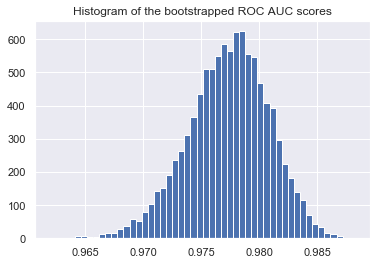

In [217]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [218]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.971 - 0.983]


In [219]:
sorted_scores.mean()

0.977320275909653

In [220]:
sorted_scores.std()

0.003513969625367953

# Save submission predictions

In [221]:
sub_df['isFraud'] = sub_preds
# sub_df.to_csv('../submissions/submission_HasVfeats2.csv', index=False)

# Feature importances

In [222]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [223]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [224]:
feature_importance_df.head()

feature  importance
2            card1        7736
0   TransactionAmt        6806
8            addr1        3970
92     card1_count        3558
10           dist1        3138

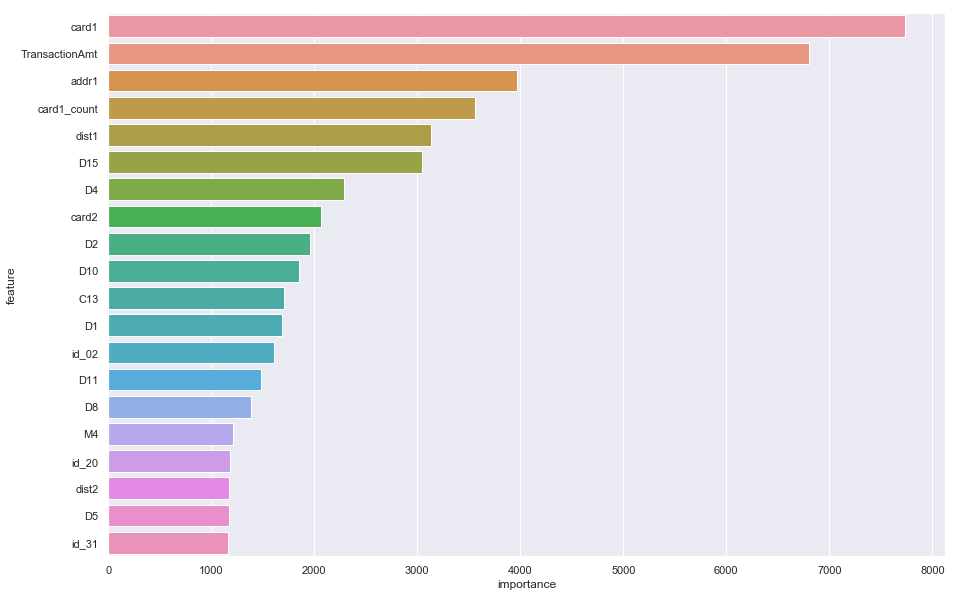

In [225]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [226]:
feature_importance_df

feature  importance
2            card1        7736
0   TransactionAmt        6806
8            addr1        3970
92     card1_count        3558
10           dist1        3138
42             D15        3048
31              D4        2291
3            card2        2062
29              D2        1961
37             D10        1851
26             C13        1705
28              D1        1685
53           id_02        1607
38             D11        1481
35              D8        1384
46              M4        1208
71           id_20        1182
11           dist2        1177
32              D5        1169
82           id_31        1168
14              C1        1145
15              C2        1133
30              D3        1093
12   P_emaildomain        1030
19              C6        1029
70           id_19         979
47              M5         885
56           id_05         856
48              M6         803
91      DeviceInfo         734
27             C14         725
41             D14         716
24             C11         716
57           id_06         710
52           id_01         664
36              D9         656
50              M8         643
22              C9         630
18              C5         519
51              M9         510
49              M7         464
33              D6         446
45              M3         442
39             D12         433
25             C12         317
21              C8         303
34              D7         303
81           id_30         302
40             D13         291
44              M2         289
23             C10         250
89           id_38         210
17              C4         204
13   R_emaildomain         185
84           id_33         177
6            card5         174
60           id_09         146
90      DeviceType         144
66           id_15         138
54           id_03         127
64           id_13         127
62           id_11         113
20              C7         105
88           id_37          88
58           id_07          81
63           id_12          80
4            card3          70
93     HasV53toV74          67
59           id_08          65
43              M1          54
87           id_36          51
85           id_34          51
1        ProductCD          37
83           id_32          35
16              C3          30
55           id_04          29
67           id_16          27
7            card6          20
79           id_28          19
61           id_10          19
72           id_21          18
74           id_23          14
86           id_35          14
80           id_29          13
76           id_25           9
65           id_14           9
69           id_18           4
78           id_27           1
5            card4           1
68           id_17           1
9            addr2           0
77           id_26           0
73           id_22           0
75           id_24           0

# Without any V features

In [227]:
train = train.drop('HasV53toV74', axis=1)
test = test.drop('HasV53toV74', axis=1)

In [253]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9  id_01    id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  \
0  NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1  NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    F    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3  NaN    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4  NaN    0.0  70787.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   id_10  id_11     id_12 id_13  id_14 id_15     id_16  id_17 id_18  id_19  \
0    NaN    NaN       NaN   NaN    NaN   NaN       NaN    NaN   NaN    NaN   
1    NaN    NaN       NaN   NaN    NaN   NaN       NaN    NaN   NaN    NaN   
2    NaN    NaN       NaN   NaN    NaN   NaN       NaN    NaN   NaN    NaN   
3    NaN    NaN       NaN   NaN    NaN   NaN       NaN    NaN   NaN    NaN   
4    NaN  100.0  NotFound   NaN -480.0   New  NotFound  166.0   NaN  542.0   

   id_20 id_21 id_22 id_23 id_24 id_25 id_26 id_27 id_28     id_29  \
0    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   
1    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   
2    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   
3    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   
4  144.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   New  NotFound   

         id_30                id_31 id_32      id_33           id_34 id_35  \
0          NaN                  NaN   NaN        NaN             NaN   NaN   
1          NaN                  NaN   NaN        NaN             NaN   NaN   
2          NaN                  NaN   NaN        NaN             NaN   NaN   
3          NaN               

# Splitting into train, val, and test

In [228]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [229]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [230]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [231]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [232]:
X_train.shape

(583369, 93)

In [233]:
X_val.shape

(7171, 93)

In [234]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [235]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [236]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [237]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994292	valid_1's auc: 0.969038
[100]	training's auc: 0.999162	valid_1's auc: 0.974288
[150]	training's auc: 0.999864	valid_1's auc: 0.976045
[200]	training's auc: 0.999974	valid_1's auc: 0.976875
Early stopping, best iteration is:
[194]	training's auc: 0.999968	valid_1's auc: 0.977348


# Predict on test sets

In [238]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [239]:
sub_preds

array([1.98651701e-05, 7.82802553e-04, 2.42695130e-05, ...,
       5.14762880e-04, 3.53956853e-04, 2.42844997e-04])

In [240]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9773481996416724


# Bootstrapping

In [241]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

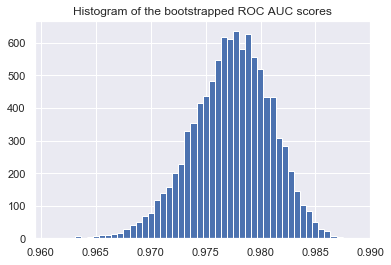

In [242]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [243]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.971 - 0.983]


In [244]:
sorted_scores.mean()

0.9773332247282067

In [245]:
sorted_scores.std()

0.003594605339174236

# Save submission predictions

In [246]:
sub_df['isFraud'] = sub_preds
# sub_df.to_csv('../submissions/submission_HasVfeats2.csv', index=False)

# Feature importances

In [247]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [248]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [249]:
feature_importance_df.head()

feature  importance
2            card1        7212
0   TransactionAmt        6954
8            addr1        3905
92     card1_count        3535
10           dist1        3388

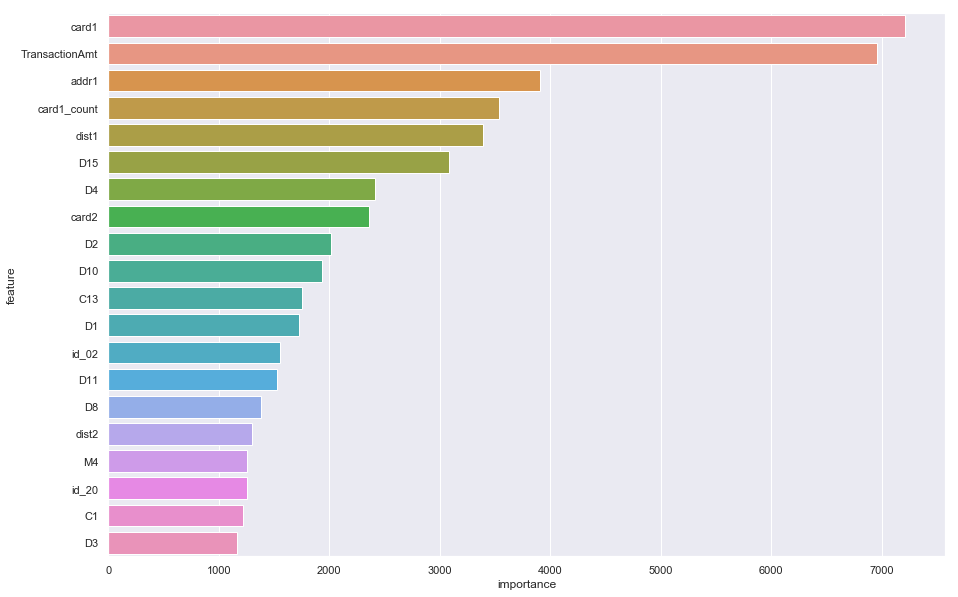

In [250]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [251]:
feature_importance_df

feature  importance
2            card1        7212
0   TransactionAmt        6954
8            addr1        3905
92     card1_count        3535
10           dist1        3388
42             D15        3088
31              D4        2416
3            card2        2358
29              D2        2021
37             D10        1934
26             C13        1759
28              D1        1728
53           id_02        1552
38             D11        1531
35              D8        1382
11           dist2        1301
46              M4        1260
71           id_20        1257
14              C1        1220
30              D3        1162
82           id_31        1146
32              D5        1105
15              C2        1072
12   P_emaildomain        1048
70           id_19        1045
19              C6         940
48              M6         912
47              M5         871
56           id_05         842
91      DeviceInfo         757
24             C11         733
41             D14         723
57           id_06         709
27             C14         694
22              C9         685
52           id_01         660
36              D9         634
50              M8         620
51              M9         562
18              C5         547
45              M3         477
49              M7         451
33              D6         420
39             D12         409
21              C8         314
44              M2         314
40             D13         312
25             C12         295
81           id_30         287
23             C10         264
34              D7         247
17              C4         212
6            card5         204
13   R_emaildomain         190
89           id_38         186
84           id_33         168
60           id_09         149
66           id_15         132
62           id_11         128
54           id_03         127
90      DeviceType         122
64           id_13         121
20              C7         102
63           id_12          89
88           id_37          82
58           id_07          70
4            card3          63
59           id_08          60
87           id_36          57
43              M1          53
85           id_34          48
1        ProductCD          41
83           id_32          33
67           id_16          31
61           id_10          29
55           id_04          26
7            card6          24
16              C3          24
72           id_21          20
86           id_35          18
74           id_23          13
65           id_14          11
79           id_28           8
80           id_29           8
76           id_25           5
69           id_18           3
77           id_26           2
68           id_17           2
5            card4           1
73           id_22           0
9            addr2           0
78           id_27           0
75           id_24           0